<a href="https://colab.research.google.com/github/EleonoraProietti/Master-Data-Analytics---ProfessionAI---Python-with-Google-Colab/blob/main/Sentiment_Analysis_on_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective

Estimate public consensus toward Bitcoin by analyzing tweets contained in the provided dataset, measuring sentiment, evaluating engagement, and comparing sentiment trends with daily BTC/USD price variations.

In [ ]:
# Spark installation and libraries
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

!pip install -q pyspark==4.0.0 findspark vaderSentiment matplotlib pandas scipy langdetect emoji regex requests

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 46.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 32.5 MB/s eta 0:00:00


In [ ]:
# Setup PySpark
import os

# Download and extract Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.4.3/spark-3.4.3-bin-hadoop3.tgz
!tar xf spark-3.4.3-bin-hadoop3.tgz

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.3-bin-hadoop3"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .appName("BitcoinSentimentAnalysis") \
  .config("spark.ui.showConsoleProgress", "false") \
  .getOrCreate()

print("Spark ready: ", spark)

Spark ready:  <pyspark.sql.session.SparkSession object at 0x78443eb1f770>


# Dataset and Preparation
Dataset loaded with columns: id, user, fullname, url, timestamp, replies, likes, retweets, text.

Text preprocessing: removal of URLs, mentions, hashtags, emojis, and non-informative characters; lowercasing; removal of empty tweets or those shorter than 5 characters; deduplication.

Language detection with langdetect and retention of English-language tweets only.

Timestamp conversion and use of date only (yyyy-MM-dd) for daily and monthly aggregations.

In [ ]:
# Upload csv file
csv_name = 'bitcoin_tweets.csv'
df_raw= spark.read.csv(csv_name, header=True, inferSchema=True)
print("Columns detected: ", df_raw.columns)
df_raw.show(5, truncate=120)

Columns detected:  ['id', 'user', 'fullname', 'url', 'timestamp', 'replies', 'likes', 'retweets', 'text']
+----------------------+-------------+-------------------+----+----------------------+-------+-----+--------+------------------------------------------------------------------------------------------------------------------------+
|                    id|         user|           fullname| url|             timestamp|replies|likes|retweets|                                                                                                                    text|
+----------------------+-------------+-------------------+----+----------------------+-------+-----+--------+------------------------------------------------------------------------------------------------------------------------+
|1.1329770553003008e+18| KamdemAbdiel|      Abdiel kamdem|null|2019-05-27 11:49:14+00|    0.0|  0.0|     0.0|              È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 

In [ ]:
# Normalization of names and timestamp conversion
from pyspark.sql import functions as F
tweets = df_raw.select(
    F.col("id"),
    F.col("user"),
    F.col("fullname"),
    F.col("url"),
    F.col("timestamp").alias("created_at"),
    F.col("replies"),
    F.col("likes"),
    F.col("retweets"),
    F.col("text")
)

tweets = tweets.withColumn("likes", F.coalesce(F.col("likes").cast("long"), F.lit(0))) \
               .withColumn("replies", F.coalesce(F.col("replies").cast("long"), F.lit(0))) \
               .withColumn("retweets", F.coalesce(F.col("retweets").cast("long"), F.lit(0)))

print("Normalized scheme: ")
tweets.printSchema()
tweets.select("created_at", "likes", "replies", "retweets","text").show(5, truncate=120)

Normalized scheme: 
root
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- url: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- replies: long (nullable = false)
 |-- likes: long (nullable = false)
 |-- retweets: long (nullable = false)
 |-- text: string (nullable = true)

+----------------------+-----+-------+--------+------------------------------------------------------------------------------------------------------------------------+
|            created_at|likes|replies|retweets|                                                                                                                    text|
+----------------------+-----+-------+--------+------------------------------------------------------------------------------------------------------------------------+
|2019-05-27 11:49:14+00|    0|      0|       0|              È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BIT

In [ ]:
# Parsing timestamp
from pyspark.sql.functions import to_timestamp, date_format
from pyspark.sql import functions as F

tweets = tweets.withColumn("created_ts",
                           to_timestamp("created_at", "yyyy-MM-dd HH:mm:ssX"))

tweets = tweets.withColumn("created_ts",
                            F.coalesce(F.col("created_ts"), to_timestamp(F.col("created_at"), "yyyy-MM-dd HH:mm:ssX")))

tweets = tweets.withColumn("date", date_format("created_ts", "yyyy-MM-dd")) \
                .withColumn("month", date_format("created_ts", "yyyy-MM"))

print("Righe con created_ts NULL: ", tweets.filter(F.col("created_ts").isNull()).count())
tweets= tweets.filter(F.col("created_ts").isNotNull())
print("Tweet con data valida: ", tweets.count())
tweets.select("created_at", "created_ts", "date").show(5, truncate=120)

Righe con created_ts NULL:  130386
Tweet con data valida:  99997
+----------------------+-------------------+----------+
|            created_at|         created_ts|      date|
+----------------------+-------------------+----------+
|2019-05-27 11:49:14+00|2019-05-27 11:49:14|2019-05-27|
|2019-05-27 11:49:18+00|2019-05-27 11:49:18|2019-05-27|
|2019-05-27 11:49:06+00|2019-05-27 11:49:06|2019-05-27|
|2019-05-27 11:49:22+00|2019-05-27 11:49:22|2019-05-27|
|2019-05-27 11:49:23+00|2019-05-27 11:49:23|2019-05-27|
+----------------------+-------------------+----------+
only showing top 5 rows



In [ ]:
# Text prepocessing (cleaning, noise removal)
!pip install emoji --quiet
import re
import emoji as emoji_lib
import regex as reg
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, length
from pyspark.sql import functions as F

def clean_text_py(s):
  if s is None:
    return None
  t = str(s)
  t = re.sub(r'http\S+|www\.\S+', ' ', t)
  t = re.sub(r'@\w+', ' ', t)
  t = re.sub(r'#', ' ', t)
  t = emoji_lib.replace_emoji(t,replace = ' ')
  t = re.sub(r"[^0-9A-Za-z'\s]", ' ', t)
  t = t.lower()
  t = re.sub(r'\s+', ' ', t).strip()
  if len(t) == 0:
    return None
  return t

clean_text_udf = udf(lambda z: clean_text_py(z), StringType())

tweets = tweets.withColumn("text_clean", clean_text_udf(F.col("text")))

# Remove tweets that are too short
tweets = tweets.filter(F.col("text_clean").isNotNull())
tweets = tweets.filter(length(F.col("text_clean")) >= 5)
tweets = tweets.dropDuplicates(["text_clean"])

print("After preprocessing (count): ", tweets.count())
tweets.select("text", "text_clean").show(5, truncate = 120)

After preprocessing (count):  64905
+------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                    text|                                                                                                              text_clean|
+------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|                                            '$20K conservative prediction for #Bitcoin in 2019', says OKEx' Andy Cheung.|                                               ' 20k conservative prediction for bitcoin in 2019' says okex' a

In [ ]:
# Language detection (english only)
!pip install langdetect --quiet
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

from pyspark.sql.types import StringType
from pyspark.sql import functions as F
def detect_lang_py(txt):
    try:
      if txt is None or len(txt) < 10:
        return "unknown"
      return detect(txt)
    except:
      return "unknown"

detect_lang_udf = udf(lambda t: detect_lang_py(t), StringType())

tweets = tweets.withColumn("lang", detect_lang_udf(F.col("text_clean")))

# Only enghlish
print("Language distribution (top): ")
tweets.groupBy("lang").count().orderBy(F.col("count").desc()).show(10)

tweets_df_en = tweets.filter(F.col("lang") == "en")
print("Tweet in english after filtering: ", tweets_df_en.count())

Language distribution (top): 
+-------+-----+
|   lang|count|
+-------+-----+
|     en|50720|
|unknown| 2405|
|     tr| 1785|
|     es| 1589|
|     fr| 1101|
|     it|  747|
|     pt|  738|
|     vi|  565|
|     tl|  448|
|     nl|  433|
+-------+-----+
only showing top 10 rows

Tweet in english after filtering:  50819


# Sentiment Analysis
Sentiment computed using VADER (standard thresholds: compound ≥ 0.05 → positive; ≤ -0.05 → negative; otherwise neutral).

Both categorical labels and the continuous sentiment_compound score were calculated for more granular analysis.



In [ ]:
# Sentiment analysis with VADER via UDF
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from pyspark.sql.types import DoubleType, StringType
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

# UDF that return label
def vader_label_pt(txt):
    if txt is None:
      return "neutral"
    s = analyzer.polarity_scores(txt)
    c = s.get("compound", 0.0)
    if c >= 0.05:
      return "positive"
    elif c <= -0.05:
      return "negative"
    else:
      return "neutral"

# UDF compound numeric
def vader_compoud_py(txt):
  if txt is None:
    return 0.0
  return float(analyzer.polarity_scores(txt)["compound"])

vader_label_udf = udf(lambda t: vader_label_pt(t), StringType())
vader_comp_udf = udf(lambda t: vader_compoud_py(t), DoubleType())

tweets_df_en = tweets_df_en.withColumn("sentiment", vader_label_udf(F.col("text_clean")))
tweets_df_en = tweets_df_en.withColumn("sentiment_compound", vader_comp_udf(F.col("text_clean")))

tweets_df_en.groupBy("sentiment").count().orderBy(F.col("count").desc()).show()

+---------+-----+
|sentiment|count|
+---------+-----+
|  neutral|21747|
| positive|20630|
| negative| 8392|
+---------+-----+



# Plots and Aggregations
Multi-year monthly plot (all available dates) shown on a logarithmic scale for tweet counts (to highlight trends and peaks even when volumes vary significantly).

Monthly plot focused on 2019 (if data is available) for a detailed analysis of the requested year.

Plots display positive, negative, and neutral series for each month.



In [ ]:
# Daily aggregations for sentiment and correct engagement
from pyspark.sql import functions as F

daily_sentiment = tweets_df_en.groupBy("date", "sentiment").agg(
    F.count("*").alias("count"),
    F.avg(F.coalesce(F.col("likes"), F.lit(0))).alias("avg_likes"),
    F.avg(F.coalesce(F.col("replies"), F.lit(0))).alias("avg_replies"),
    F.avg(F.coalesce(F.col("retweets"), F.lit(0))).alias("avg_retweets")
).orderBy("date")

daily_pivot = daily_sentiment.groupBy("date").pivot("sentiment", ["positive", "negative", "neutral"]).agg(
    F.first("count").alias("count")
).na.fill(0).orderBy("date")

monthly_sent = tweets_df_en.groupBy("month", "sentiment").agg(F.count("*").alias("count")).orderBy("month")
monthly_pivot = monthly_sent.groupBy("month").pivot("sentiment", ["positive", "negative", "neutral"]).agg(F.first("count")).na.fill(0).orderBy("month")

# Engagement aggregations for sentiment
engagement_sent = tweets_df_en.groupBy("sentiment").agg(
    F.count("*").alias("n_tweets"),
    F.avg(F.col("likes")).alias("mean_likes"),
    F.avg(F.col("replies")).alias("mean_replies"),
    F.avg(F.col("retweets")).alias("mean_retweets")
)

print("Daily pivot sample: ")
daily_pivot.show(5)
print("Monthly pivot sample: ")
monthly_pivot.show(5)
print("Engagement per sentiment: ")
engagement_sent.show()

Daily pivot sample: 
+----------+--------+--------+-------+
|      date|positive|negative|neutral|
+----------+--------+--------+-------+
|2009-01-11|       0|       0|      1|
|2012-08-02|       1|       0|      0|
|2013-08-16|       0|       1|      0|
|2013-12-09|       0|       0|      1|
|2013-12-19|       1|       0|      0|
+----------+--------+--------+-------+
only showing top 5 rows

Monthly pivot sample: 
+-------+--------+--------+-------+
|  month|positive|negative|neutral|
+-------+--------+--------+-------+
|2009-01|       0|       0|      1|
|2012-08|       1|       0|      0|
|2013-08|       0|       1|      0|
|2013-12|       1|       0|      2|
|2014-02|       1|       0|      0|
+-------+--------+--------+-------+
only showing top 5 rows

Engagement per sentiment: 
+---------+--------+------------------+------------------+------------------+
|sentiment|n_tweets|        mean_likes|      mean_replies|     mean_retweets|
+---------+--------+------------------+---------

In [ ]:
# Convert redundancy aggregation
import pandas as pd
daily_pd = daily_pivot.toPandas()
monthly_pd = monthly_pivot.toPandas()
eng_pd = engagement_sent.toPandas()

daily_pd['date'] = pd.to_datetime(daily_pd['date'])
monthly_pd['month'] = pd.to_datetime(monthly_pd['month'] + "-01")

for c in ['positive', 'negative', 'neutral']:
  if c not in daily_pd.columns:
    daily_pd[c] = 0
  if c not in monthly_pd.columns:
    monthly_pd[c] = 0

print("Example monthly_pd head: ")
monthly_pd.head()

Example monthly_pd head: 


,month,positive,negative,neutral
0,2009-01-01,0,0,1
1,2012-08-01,1,0,0
2,2013-08-01,0,1,0
3,2013-12-01,1,0,2
4,2014-02-01,1,0,0


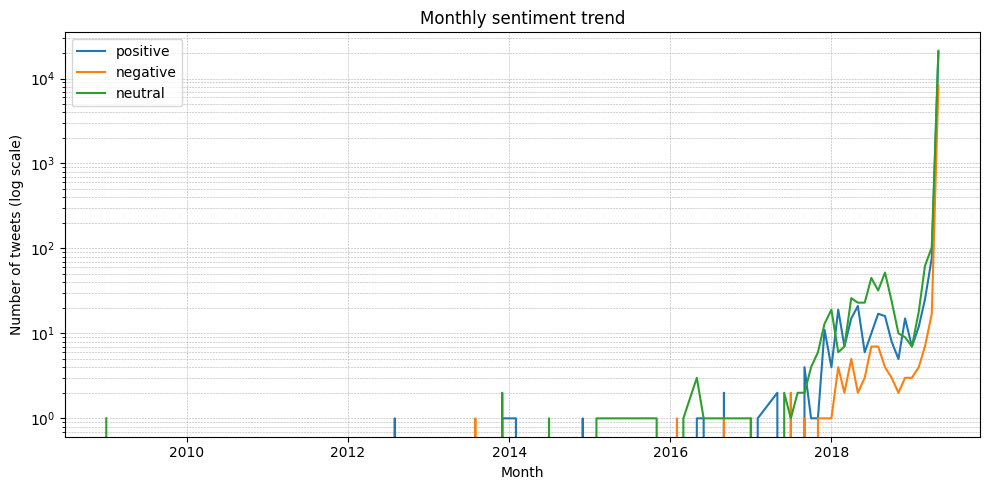

In [ ]:
# Monthly trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(monthly_pd['month'],monthly_pd['positive'], label='positive')
plt.plot(monthly_pd['month'],monthly_pd['negative'], label='negative')
plt.plot(monthly_pd['month'],monthly_pd['neutral'], label='neutral')
plt.yscale('log')
plt.xlabel("Month")
plt.ylabel("Number of tweets (log scale)")
plt.title("Monthly sentiment trend")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.4)
plt.tight_layout()
plt.show()

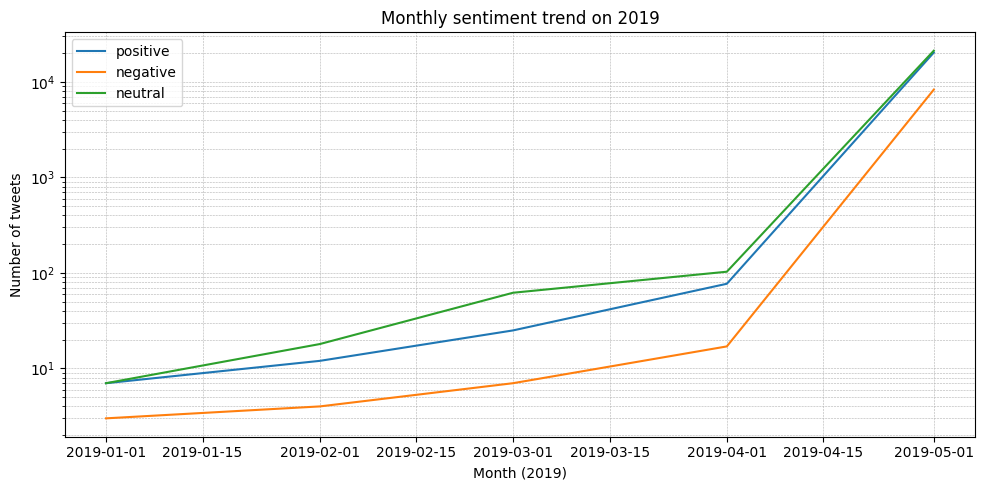

In [ ]:
# Chart on 2019
monthly_pd['year'] = monthly_pd['month'].dt.year
monthly_2019 = monthly_pd[monthly_pd['year'] == 2019]

plt.figure(figsize=(10, 5))
if len(monthly_2019) == 0:
  print("No data for 2019 in the dataset.")
else:
  plt.plot(monthly_2019['month'], monthly_2019['positive'], label='positive')
  plt.plot(monthly_2019['month'], monthly_2019['negative'], label='negative')
  plt.plot(monthly_2019['month'], monthly_2019['neutral'], label='neutral')
  plt.yscale('log')
  plt.xlabel("Month (2019)")
  plt.ylabel("Number of tweets")
  plt.title("Monthly sentiment trend on 2019")
  plt.legend()
  plt.grid(True, which="both", ls="--", linewidth=0.4)
  plt.tight_layout()
  plt.show()

# Engagement
Computed average likes, replies, and retweets by sentiment category.

Statistical validation: independent t-tests (without assuming equal variance) to compare likes and replies between positive and negative tweets, provided sample size is sufficiently large (>10 observations per group).


In [ ]:
# Detailed engagement (averages, distributions and statistical tests)
likes_df = tweets_df_en.select("sentiment", F.coalesce(F.col("likes"), F.lit(0)).alias("likes")).toPandas()
replies_df = tweets_df_en.select("sentiment", F.coalesce(F.col("replies"), F.lit(0)).alias("replies")).toPandas()

likes_pd_full = likes_df
replies_pd_full = replies_df

# Summary per sentiment
likes_summary = likes_pd_full.groupby("sentiment")["likes"].agg(["count", "mean", "median", "std"]).reset_index()
replies_summary = replies_pd_full.groupby("sentiment")["replies"].agg(["count", "mean", "median", "std"]).reset_index()

print("Summary likes per sentiment: ")
print(likes_summary)
print("\nSummary replies per sentiment: ")
print(replies_summary)

# T-test
from scipy import stats

# Likes
pos_likes = likes_pd_full[likes_pd_full["sentiment"]=="positive"]["likes"]
neg_likes = likes_pd_full[likes_pd_full["sentiment"]=="negative"]["likes"]
if len(pos_likes) > 10 and len(neg_likes) > 10:
  t_likes, p_likes = stats.ttest_ind(pos_likes, neg_likes, equal_var=False)
  print(f"\nT-test likes (positive vs negative): t={t_likes:.3f}, p={p_likes:.3e}")
else:
  print("\nSamples too small for t-test (or one of the groups has <=10 observations).")

# Replies
pos_repl = replies_pd_full[replies_pd_full["sentiment"]=="positive"]["replies"]
neg_repl = replies_pd_full[replies_pd_full["sentiment"]=="negative"]["replies"]
if len(pos_repl) > 10 and len(neg_repl) > 10:
  t_repl, p_repl = stats.ttest_ind(pos_repl, neg_repl, equal_var=False)
  print(f"\nT-test replies (positive vs negative): t={t_repl:.3f}, p={p_repl:.3e}")
else:
  print("\nSamples too small for t-test (or one of the groups has <=10 observations).")

Summary likes per sentiment: 
  sentiment  count       mean  median         std
0  negative   8396  11.732134     0.0  119.133820
1   neutral  21783  10.793325     0.0  134.827686
2  positive  20629  10.013088     0.0   83.558911

Summary replies per sentiment: 
  sentiment  count      mean  median        std
0  negative   8392  1.266206     0.0  13.736116
1   neutral  21737  1.117588     0.0  11.353772
2  positive  20628  1.426508     0.0  23.343830

T-test likes (positive vs negative): t=-1.207, p=2.275e-01

T-test replies (positive vs negative): t=0.725, p=4.685e-01


# Correlation with BTC Price
Downloaded BTC-USD historical data from the GitHub repository (file BTC-USD.csv).

Computed daily percentage change (pct_change) of the closing price.

Performed daily merge between sentiment counts and price data; calculated Pearson correlations between:

- net_sentiment = (positive − negative) / total and price pct_change

- pct_positive and pct_negative vs. price pct_change

Simple lag-1 analysis to test whether sentiment precedes price movements or vice versa.



In [ ]:
# Download BTC-USD.csv locally
import requests
btc_url = "https://raw.githubusercontent.com/Profession-AI/progetti-big-data/main/Analisi%20del%20consenso%20sul%20Bitcoin/BTC-USD.csv"

r= requests.get(btc_url)
if r.status_code == 200:
  open("/content/BTC-USD.csv", "wb").write(r.content)
  print("BTC-USD.csv scaricato su /content/BTC-USD.csv")
else:
  print("Impossibile scaricare BTC CSV, status: ", r.status_code)

BTC-USD.csv scaricato su /content/BTC-USD.csv


In [ ]:
# Read BTC CSV
btc = pd.read_csv("/content/BTC-USD.csv", parse_dates=["Date"])
btc = btc.sort_values("Date").reset_index(drop=True)
btc["pct_change"] = btc["Close"].pct_change()
btc["date"] = btc["Date"].dt.strftime("%Y-%m-%d")
btc[["Date", "Close", "pct_change"]].head()

,Date,Close,pct_change
0,2014-09-17 00:00:00+00:00,457.334015,NaN
1,2014-09-18 00:00:00+00:00,424.440002,-0.071926
2,2014-09-19 00:00:00+00:00,394.795990,-0.069843
3,2014-09-20 00:00:00+00:00,408.903992,0.035735
4,2014-09-21 00:00:00+00:00,398.821014,-0.024659


In [ ]:
# Daily sentiment and correlations
daily_pd["date_str"] = daily_pd["date"].dt.strftime("%Y-%m-%d")
merged = pd.merge(daily_pd, btc[["date", "Close", "pct_change"]], left_on = "date_str", right_on="date", how="inner")

merged["total"] = merged[["positive", "negative", "neutral"]].sum(axis=1)
merged = merged[merged["total"] > 0]
merged["pct_positive"] = merged["positive"] / merged["total"]
merged["pct_negative"] = merged["negative"] / merged["total"]
merged["net_sentiment"] = (merged["positive"] - merged["negative"]) / merged["total"]

# Correlations (Pearson)
corr_net = merged["net_sentiment"].corr(merged["pct_change"])
corr_pos = merged["pct_positive"].corr(merged["pct_change"])
corr_neg = merged["pct_negative"].corr(merged["pct_change"])

print("Merged rows: ", len(merged))
print("Correlations (Pearson): ")
print("net_sentiment vs btc_pct_change: ", corr_net)
print("pct_positive vs btc_pct_change: ", corr_pos)
print("pct_negative vs btc_pct_change: ", corr_neg)

Merged rows:  413
Correlations (Pearson): 
net_sentiment vs btc_pct_change:  -0.08597039351400704
pct_positive vs btc_pct_change:  -0.05101302547204359
pct_negative vs btc_pct_change:  0.09781123290753667


In [ ]:
# Simple lag analysise (t-1)
merged_sorted = merged.sort_values("date_str").reset_index(drop=True)
merged_sorted["pct_change_price_lag1"] = merged_sorted["pct_change"].shift(1)
merged_sorted["net_sentiment_lag1"] = merged_sorted["net_sentiment"].shift(1)

corr_sentlag_price = merged_sorted["net_sentiment_lag1"].corr(merged_sorted["pct_change"])
corr_pricelag_sent = merged_sorted["pct_change_price_lag1"].corr(merged_sorted["net_sentiment"])

print("Correlations with lag 1 day: ")
print("net_sentiment (t-1) vs price pct_change(t): ", corr_sentlag_price)
print("price pct_change (t-1) vs net_sentiment(t): ", corr_pricelag_sent)

Correlations with lag 1 day: 
net_sentiment (t-1) vs price pct_change(t):  -0.10736161430794929
price pct_change (t-1) vs net_sentiment(t):  -0.016799251425987056


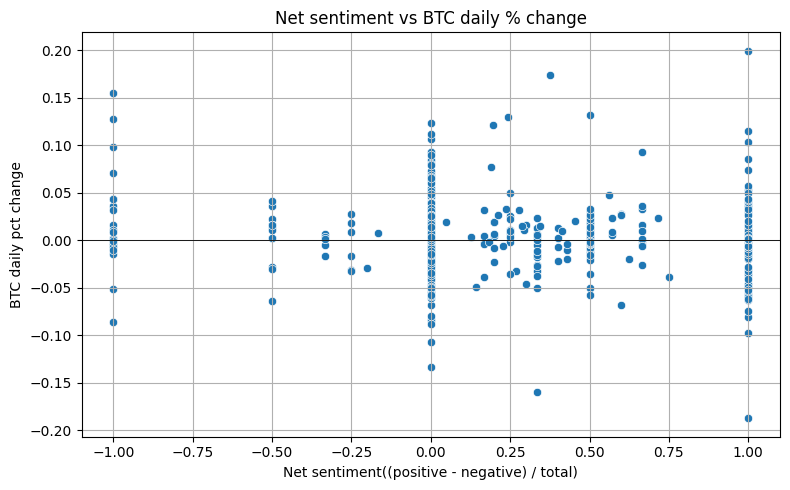

In [ ]:
# Create a Scatterplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(x=merged['net_sentiment'], y=merged['pct_change'])
plt.axhline(0, color="black", linewidth=0.6)
plt.xlabel("Net sentiment((positive - negative) / total)")
plt.ylabel("BTC daily pct change")
plt.title("Net sentiment vs BTC daily % change")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Saving results
monthly_pd.to_csv("/content/monthly_sentiment.csv", index=False)
daily_pd.to_csv("/content/daily_sentiment.csv", index=False)
eng_pd.to_csv("/content/engagement_sentiment.csv", index=False)
print("CSV salvati in /content: monthly_sentiment.csv, daily_sentiment.csv, engagement_sentiment.csv")

CSV salvati in /content: monthly_sentiment.csv, daily_sentiment.csv, engagement_sentiment.csv


## Conclusion
Main Results:
- Number of analyzed tweets (after cleaning): Tweet in english after cleaning and filtering are 50.819.

- Sentiment distribution: neutral 21.747, positive 20.630, negative 8.392

- Correlation net_sentiment vs. price: r = -0.08597

- t-test: </br>
** likes: t=-1.201, p=2.275e-01 </br>
** replies: t=0.725, p=4.685e-01

- One-day lag analysis: </br>
** net_sentimente(t-1) vs price(t): -0.10736 </br>
** price(t-1) vs net_sentiment(t): -0.01679

Correlation does not imply causation. Even if moderate positive/negative correlations emerge, one cannot conclude that sentiment causes price movements.

VADER does not capture sarcasm, irony, or complex financial language.

Filtering for English excludes non-English opinions.